# Symmetrisierte Daten

Wenn man die Daten auf die ganze reziproke Gitterzelle fortsetzt, kann man das Gradient Descent auch ohne eingebaute Symmetrie verwenden. Dabei kommen deutlich bessere Modelle raus.

In [1]:
import setup
import numpy as np
from matplotlib import pyplot as plt
np.set_printoptions(precision=3, suppress=True)
from common import *

In [2]:
# read the data from Quantum Espresso
import qespresso_interface as qe
material = qe.QECrystal("nitinol_0K_nscf_8", [], [], [], 0)
k_smpl, _, ref_bands, symmetries, fermi_energy = material.read_bands()
print("Symmetries:", len(symmetries))
print("k_points:", len(k_smpl))
#k_smpl = -k_smpl
k_smpl, ref_bands = Symmetry(symmetries).realize_symmetric_data(np.round(k_smpl, 3), ref_bands)
#print(len(k_smpl))
# read wannier tight binding file
w_neighbors, w_params, w_r_params = material.read_wannier_tb()
#assert len(w_params[0]) == len(ref_bands[0])
print(len(w_params[0]), "bands")
#w_params[0] /= 2

wannier_tb_nitinol = BandStructureModel.init_tight_binding(Symmetry.none(), w_neighbors, len(w_params[0]), cos_reduced=False, exp=True)
wannier_tb_nitinol.set_params_complex(w_params)

path = kpaths.KPath('G').to('X').to('M').to('G').to('R').to('X')
interpolator = kpaths.interpolate(k_smpl, ref_bands, Symmetry.none(), method='cubic')
path.plot(wannier_tb_nitinol, '-')
path.plot(interpolator, '--')
plt.ylim(8, 24)
plt.show()

Symmetries: 48
k_points: 35


FileNotFoundError: [Errno 2] No such file or directory: 'nitinol_0K_nscf_8_tb.dat'

Symmetries: 48
loss: 8.01e-01 (max band-error [1.111 0.827 0.78  0.678 0.77  1.027 0.903 0.871 1.057 0.958 1.391 1.288])
aborted
final loss: 6.49e-01 (max band-error [0.632 0.674 0.731 0.666 0.518 0.822 0.859 0.746 0.832 0.891 1.513 1.348])
loss: 4.26e-01 (max band-error [0.419 0.53  0.374 0.536 0.43  1.011 0.841 0.453 0.535 0.46  1.238 1.126])
aborted
final loss: 3.66e-01 (max band-error [0.398 0.355 0.452 0.369 0.375 0.456 0.511 0.422 0.47  0.353 0.915 1.098])


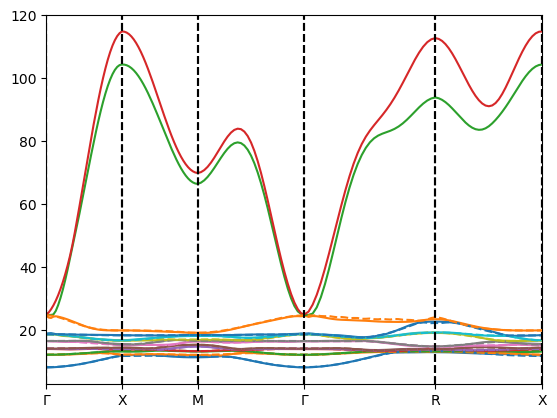

In [3]:
# read the data from Quantum Espresso
import qespresso_interface as qe
material = qe.QECrystal("nitinol_0K", [], [], [], 0)
k_smpl, _, ref_bands, symmetries, fermi_energy = material.read_bands()
print("Symmetries:", len(symmetries))
ref_bands = ref_bands[:,8:]
k_smpl, ref_bands = Symmetry(symmetries).realize_symmetric_data(k_smpl, ref_bands)

# now start my algorithm to find good matrices
additional_bands = 2
band_offset = 0 # = additional bands below reference

weights = np.ones(len(ref_bands[0]))
weights[0] = 0.5
weights[-1] = 1.0

neighbors = ((0, 0, 0), (1, 0, 0), (1, 1, 0), (1, 1, 1)) # works well
neighbors = Symmetry.cubic(True).complete_neighbors(neighbors)

tb_nitinol = BandStructureModel.init_tight_binding_from_ref(Symmetry.none(), neighbors, k_smpl, ref_bands, band_offset, additional_bands, cos_reduced=True, exp=False)
tb_nitinol.optimize(k_smpl, 1, ref_bands, weights, band_offset, 1000, 32, train_k0=False, regularization=0.99, learning_rate=0.5)
tb_nitinol.optimize(k_smpl, 1, ref_bands, weights, band_offset, 2000, 32, train_k0=True, regularization=0.999, learning_rate=0.5)

path = kpaths.KPath('G').to('X').to('M').to('G').to('R').to('X')
interpolator = kpaths.interpolate(k_smpl, ref_bands, Symmetry.none(), method='cubic')
path.plot(tb_nitinol, '-')
path.plot(interpolator, '--')
#plt.ylim(8, 24)
plt.show()

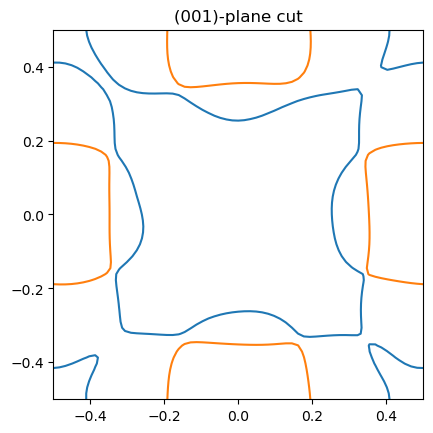

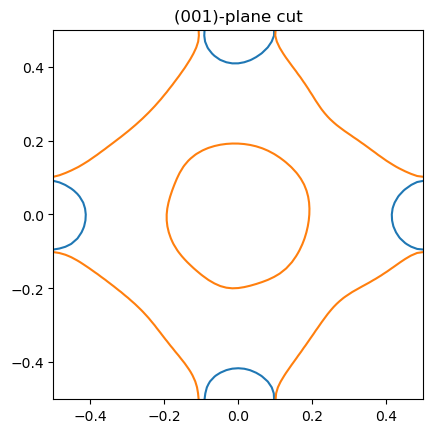

In [19]:
fs.plot_2D_fermi_surface(tb_nitinol, fermi_energy, N=63)

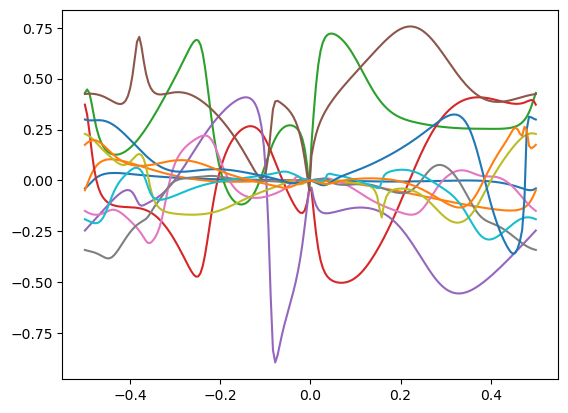

In [20]:
# plot how the unitary rotation matrices behave by plotting
# a few components of the matrices along a k-line
k_x = np.linspace(-0.5, 0.5, 200)
k_line = k_x[:,None] * np.array([[1, 0, 0]]) + np.array([[1, 1, 1]]) * 0.0
Uk = np.linalg.eigh(tb_nitinol.f(k_line))[1]
for i in range(6):
    plt.plot(k_x, np.abs(Uk[:,0,i]) * np.real(Uk[:,1,i] / Uk[:,0,i]))
    plt.plot(k_x, np.abs(Uk[:,0,i]) * np.real(Uk[:,2,i] / Uk[:,0,i]))
plt.show()

Now do the same for copper, which has a different cell shape, but again cubic symmetry.

In [5]:
# read the data from Quantum Espresso
import qespresso_interface as qe
material = qe.QECrystal("cu", [], [], [], 0)
k_smpl, _, ref_bands, symmetries, fermi_energy = material.read_bands()
print("Symmetries:", len(symmetries))
k_smpl, ref_bands = Symmetry.cubic(True).realize_symmetric_data(k_smpl, ref_bands)

# now start my algorithm to find good matrices
additional_bands = 3
band_offset = 1 # = additional bands below reference

weights = np.ones(len(ref_bands[0]))
weights[0] = 0.1
weights[-1] = 0.1
weights[-2] = 0.1

basis_transform = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]]) / 2.0
neighbors = ((0, 0, 0), (1, 0, 0), (1, 1, 0), (1, 1, 1))
neighbors = Symmetry.cubic(True).complete_neighbors(neighbors) # this can be done before or after the basis_transform is applied for different results
neighbors = np.array(neighbors) @ basis_transform

tb_cu = BandStructureModel.init_tight_binding_from_ref(Symmetry.none(), neighbors, k_smpl, ref_bands, band_offset, additional_bands, cos_reduced=True)
tb_cu.optimize(k_smpl, 1, ref_bands, weights, band_offset, 1000, 21, train_k0=False, regularization=0.995, learning_rate=0.25)
tb_cu.optimize(k_smpl, 1, ref_bands, weights, band_offset, 2000, 21, train_k0=True, regularization=0.999, learning_rate=0.25)

Symmetries: 48
final loss: 6.03e-01 (max band-error [2.284 1.047 0.564 0.491 0.702 5.069 1.118 4.017])])
final loss: 1.73e-01 (max band-error [0.421 0.275 0.205 0.212 0.201 0.371 0.557 1.723])


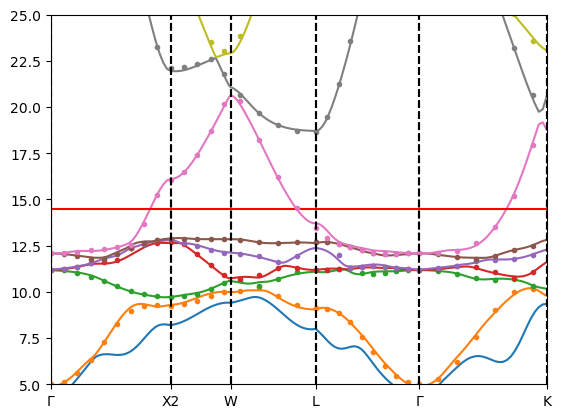

In [6]:
import kpaths
importlib.reload(kpaths)
path = kpaths.KPath('G').to('X2').to('W').to('L').to('G').to('K')
path2 = kpaths.KPath('G').to('X2', 9).to('W', 9).to('L', 9).to('G', 9).to('K', 9*3)
interpolator = kpaths.interpolate_unstructured(k_smpl, ref_bands, Symmetry.none())
path.plot(tb_cu, '-')
plt.axhline(fermi_energy, color='r')
path2.plot(interpolator, '.', band_offset=1)
plt.ylim(5, 25)
plt.show()

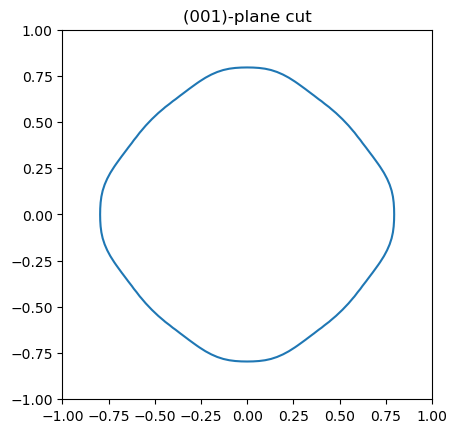

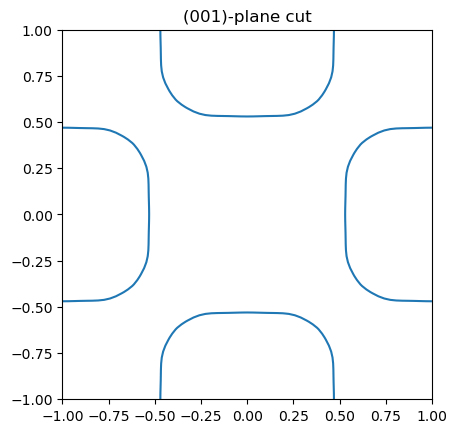

In [20]:
fs.plot_2D_fermi_surface(tb_cu, fermi_energy, N=63, k_range=[-1, 1])